In [1]:
%load_ext autoreload
%autoreload 2


# Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
import xgboost as xgb


from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import (f1_score,
                             confusion_matrix,  
                             roc_curve, 
                             auc,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             PrecisionRecallDisplay
                            )

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe


# Reproduce processing pipeline 

In [3]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECTS = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_trial_classifier_hyperopt/subjects.json'

In [5]:
pipeline = (ClassifierPipe(DATA_PATH)
                      .read_raw_data()
                      .calculate_max_min_signal()
                      .drop_features(["event", "trial"])
                      .split_data(target='action',
                                  load_subject_ids = True, 
                                  subject_ids_path=SUBJECTS,
                                  save_subject_ids=False)
                      .transform_data(numeric_target_dict={'avoid': 1, 'escape': 0})
                      )

# Train Classifier using opimtized parameteres

In [31]:
best_params =  {'booster': 'gbtree',
                'gamma': 1, 
                'learning_rate': 0.05, 
                'max_depth': 6, 
                'max_leaves': 0, 
                'min_child_weight': 8, 
                'n_estimators': 200, 
                'reg_alpha': 1.0, 
                'reg_lambda': 3.0, 
                'subsample': 0.2}
model = xgb.XGBClassifier(objective = 'binary:logistic',
                          **best_params)
model.fit(pipeline.X_train, pipeline.y_train)
dev_pred = model.predict(pipeline.X_dev)
test_pred = model.predict(pipeline.X_test)

train_score = f1_score(pipeline.y_train, model.predict(pipeline.X_train))
dev_score = f1_score(pipeline.y_dev, dev_pred)
test_score = f1_score(pipeline.y_test, test_pred)

print(f"Train F1 score: {train_score} \n Dev F1 score: {dev_score} \n Test F1 score: {test_score}")


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


Train F1 score: 0.862389697114238 
 Dev F1 score: 0.5622895622895623 
 Test F1 score: 0.7301302200269422


# Plot Performance

# Get Dataframe for plotting

In [32]:
def get_feature_names(pipeline):
    num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
    cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
    return num_cols + cat_cols

def get_test_frame(pipeline, predicted_vals):
    cols = get_feature_names(pipeline)
    df = (pd.DataFrame(pipeline.X_test, columns=cols)
          .assign(predicted_values = predicted_vals,
                  true_values = pipeline.y_test.reset_index(drop=True))
          )
    return (df
            .melt(id_vars = df.drop(columns = ['predicted_values', 'true_values']).columns, 
                  value_vars = ['predicted_values', 'true_values'],
                  value_name = 'inference_values', 
                  var_name = 'inference_type')
    )

In [33]:
test_df = get_test_frame(pipeline, test_pred)
test_df

,mouse_id,day,trial_count,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,sensor_D1,sensor_D2,sensor_DA,sex_F,sex_M,inference_type,inference_values
0,-1.671841,-1.37011,-1.536610,-0.030343,0.813525,1.266743,1.863203,0.332973,1.0,0.0,0.0,1.0,0.0,predicted_values,0
1,-1.671841,-0.39679,-0.552013,0.629932,2.255115,1.842941,1.586664,1.535739,1.0,0.0,0.0,1.0,0.0,predicted_values,0
2,-1.671841,-0.39679,-0.534740,-1.981333,-0.869643,-3.642315,-2.022754,-4.076210,1.0,0.0,0.0,1.0,0.0,predicted_values,0
3,-1.671841,-0.39679,-0.413824,-0.581277,-0.612715,-1.586780,-0.366833,-2.256904,1.0,0.0,0.0,1.0,0.0,predicted_values,1
4,-1.671841,-0.39679,-0.396550,1.126362,2.060430,4.376417,5.998309,1.560771,1.0,0.0,0.0,1.0,0.0,predicted_values,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3561,0.677129,0.57653,-0.016531,1.106921,0.405307,0.631086,1.381668,-0.258200,0.0,0.0,1.0,0.0,1.0,true_values,0
3562,0.677129,0.57653,0.000743,0.332078,0.166529,-0.523898,0.058925,-0.913539,0.0,0.0,1.0,0.0,1.0,true_values,0
3563,0.677129,1.06319,0.501678,-0.614339,-0.260358,-1.284287,-0.505899,-1.631191,0.0,0.0,1.0,0.0,1.0,true_values,0
3564,0.677129,1.06319,0.518952,-0.891657,-0.010662,-1.158474,-0.825248,-1.126358,0.0,0.0,1.0,0.0,1.0,true_values,0


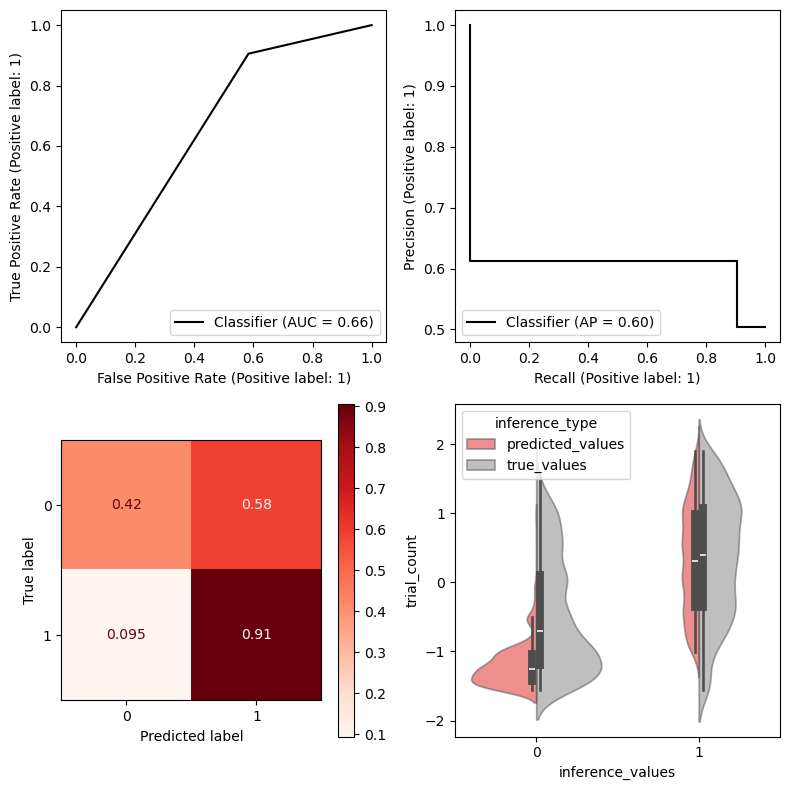

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
RocCurveDisplay.from_predictions(pipeline.y_test,
                                 test_pred, 
                                 color = 'k', 
                                 ax = ax[0,0])

PrecisionRecallDisplay.from_predictions(pipeline.y_test,
                                        test_pred,
                                        color = 'k',
                                        ax = ax[0,1])

ConfusionMatrixDisplay.from_predictions(pipeline.y_test,
                                               test_pred, 
                                               normalize='true',
                                               cmap = 'Reds',
                                               ax = ax[1,0])

sns.violinplot(data = test_df,
               x = 'inference_values', 
               y = 'trial_count', 
               split = True, 
               hue = 'inference_type',
               alpha = 0.5,
               palette=['red', 'grey'],
               ax = ax[1,1])
# ax[3].legend(loc = 'outer right', bbox_to_anchor = (1, 0.5))
plt.tight_layout()

# Feature importance

In [36]:
explainer = shap.TreeExplainer(model, pipeline.X_train)
shap_values = explainer(pipeline.X_train)

[14:15:47] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 9793/9926 [00:44<00:00]        

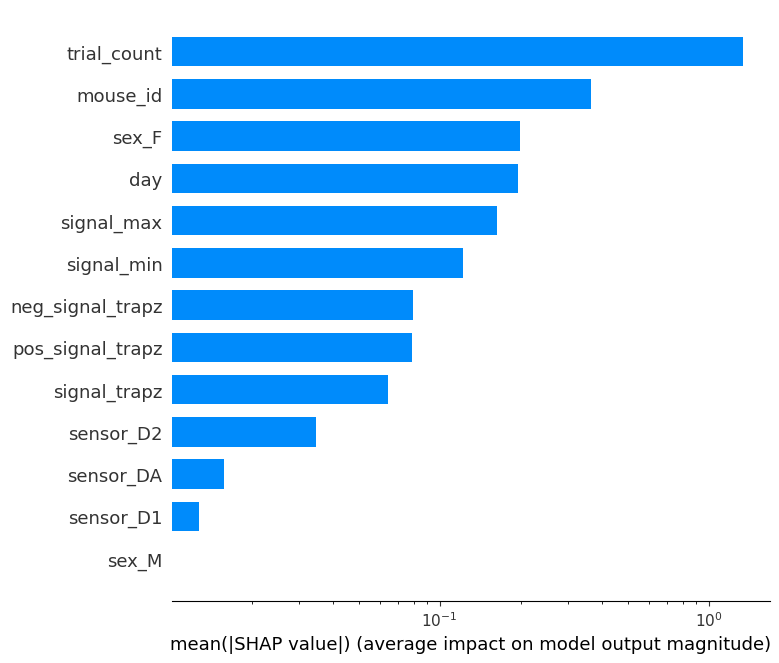

In [38]:
cols = get_feature_names(pipeline)
shap.summary_plot(shap_values, pipeline.X_train, plot_type="bar", feature_names=cols, show=False)
plt.xscale('log')
plt.show()

In [51]:
embeddings = TSNE(n_components=2).fit_transform(shap_values.values)


cdict1 = {
    "red": (
        (0.0, 0.11764705882352941, 0.11764705882352941),
        (1.0, 0.9607843137254902, 0.9607843137254902),
    ),
    "green": (
        (0.0, 0.5333333333333333, 0.5333333333333333),
        (1.0, 0.15294117647058825, 0.15294117647058825),
    ),
    "blue": (
        (0.0, 0.8980392156862745, 0.8980392156862745),
        (1.0, 0.3411764705882353, 0.3411764705882353),
    ),
    "alpha": ((0.0, 1, 1), (0.5, 1, 1), (1.0, 1, 1)),
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap("RedBlue", cdict1)

<Axes: >

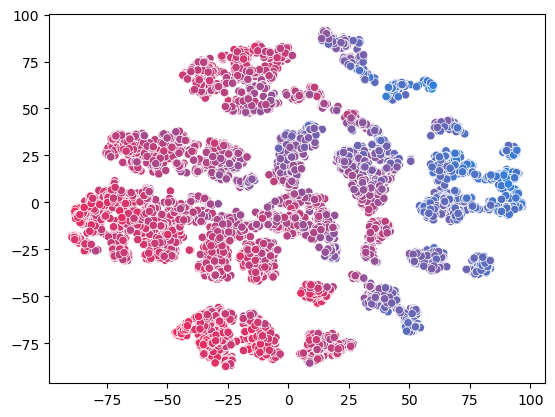

In [58]:
sns.scatterplot(x = embeddings[:,0], y = embeddings[:,1], c = shap_values.values.sum(1).astype(float), cmap= red_blue_solid)

In [49]:
embeddings.shape

(9926, 2)

In [63]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=len(cols), random_state = 42)
clusters = k_means.fit_predict(embeddings)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


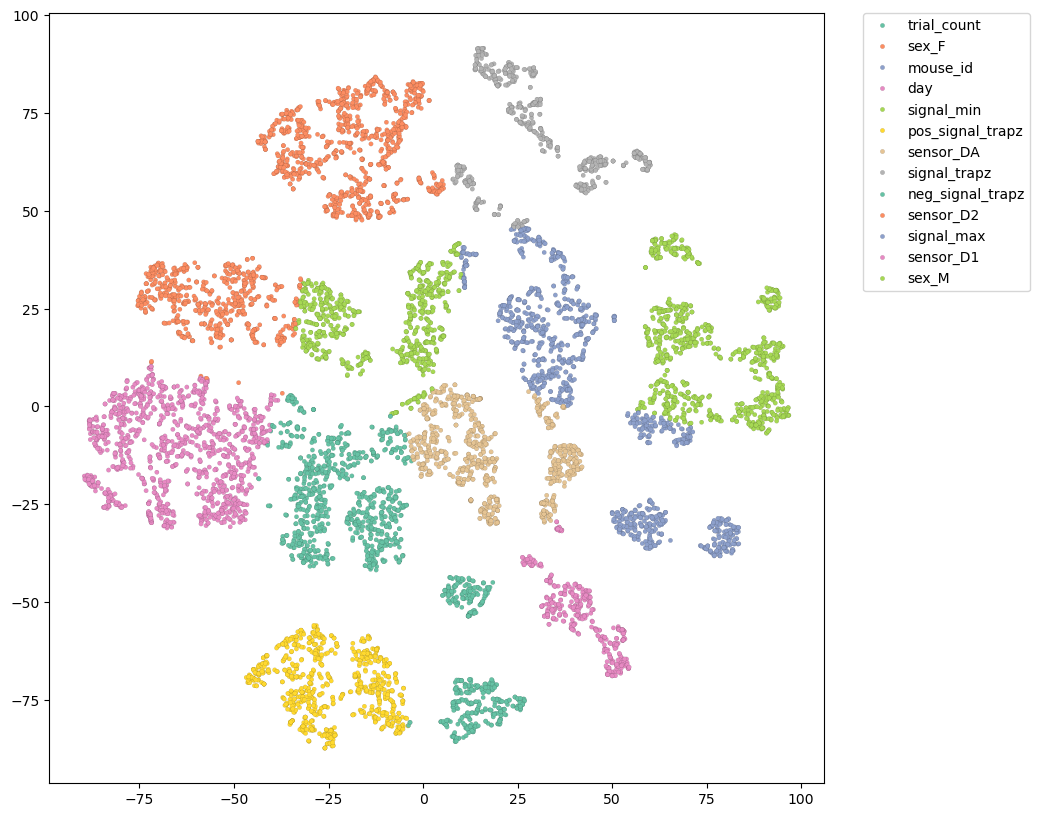

In [153]:
feautre_importance = pd.Series(model.feature_importances_, index = cols).sort_values(ascending=False)
labels = feautre_importance.index

fig, ax = plt.subplots(figsize = (10,10))
qualitative_colors = sns.color_palette("Set2", len(labels))


sns.scatterplot(x = embeddings[:,0],
                y = embeddings[:,1], 
                hue = clusters, 
                palette = qualitative_colors,
                legend = 'full',
                s = 10,
                # alpha = 0.8,
                edgecolor = 'k', 
                linewidth = 0.05,
                ax = ax)
h,l = ax.get_legend_handles_labels()
ax.legend(h, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


TypeError: list.count() takes exactly one argument (0 given)